In [66]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
import polars as pl

from tqdm import tqdm
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=False)

from dataclasses import dataclass

plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': (12,6)
                     })

In [67]:
# with uproot.open('/home/pgranger/atmospherics/sum_50k_hd_AV.root') as f:
filename='merged_caf_pfpfix_hd'
filepath='/home/henrique/Documents/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/'
# file = f'{filepath}{filename}.root'
# def loadData(file):
#     with uproot.open(file) as f:
#         tree = f['cafTree']
#         cols = [key for key in tree.keys() if "Jagged" not in str(tree[key].interpretation)]

#         data = f['cafTree'].arrays(cols, library='np')
#         # df = pl.from_pandas(pd.DataFrame(data))
#         return df
#     # print(df)
# df:pl.DataFrame
# df = loadData(file)
# df.write_parquet(f'{filepath}{filename}.parquet')
# dfold = loadData('/home/henrique/Documents/Atmos_Pandora/data/atm_50k_hd_AV/caf_sum.root')
df = pl.read_parquet(f'{filepath}{filename}.parquet')

In [68]:
pl.Config.set_tbl_rows(20)
@dataclass
class Flavour:
    pdg:int
    name:str
    name_latex:str
    cvn:str
    reco_en:str

flavours = {
    -16: Flavour(-16, "nutaubar", r"$\overline{\nu}_\tau$", "rec.cvnnutau", "rec.Ev_reco_nutau"),
    -14: Flavour(-14, "numubar", r"$\overline{\nu}_\mu$", "rec.cvnnumu", "rec.Ev_reco_numu"),
    -12 : Flavour(-12, "nuebar", r"$\overline{\nu}_e$", "rec.cvnnue", "rec.Ev_reco_nue"),
    12: Flavour(12, "nue", r"$\nu_e$", "rec.cvnnue", "rec.Ev_reco_nue"),
    14: Flavour(14, "numu", r"$\nu_\mu$", "rec.cvnnumu", "rec.Ev_reco_numu"),
    16: Flavour(16, "nutau", r"$\nu_\tau$", "rec.cvnnutau", "rec.Ev_reco_nutau"),
    0: Flavour(0, "NC", r"$\nu_{nc}$", "rec.cvnnc", "rec.Ev_reco")
}

def get_max():
    return  pl.max('rec.cvnnue','rec.cvnnumu','rec.cvnnutau','rec.cvnnc')

def define_flavour(df:pl.DataFrame) -> pl.DataFrame: 
    df = df.with_columns(
        Flavour = pl.when(get_max()==None).then(0).otherwise(
        pl.when((pl.col('rec.cvnnue') >= 0.85)).then(12).otherwise(
        pl.when(pl.col('rec.cvnnumu')>=0.5).then(14).otherwise(
        pl.when(pl.col('rec.cvnnc')>=0.8).then(0).otherwise(16)
        )))
    )
    return df

def fill_empty_categories(df, labels):

    empty_result = pl.DataFrame({ col: [0. for _ in labels] for col in df.columns })
    empty_result.with_columns(pl.Series(name='Ecut', values=labels))

    # works, but need to add manually.
    # empty_result = pl.DataFrame({'purity': 0., 'completeness': 0., 'total_events':0., 'Ecut': labels})
    empty_result = empty_result.with_columns(Ecut=pl.col('Ecut').cast(pl.Int16))

    out = pl.concat([empty_result,df],how='diagonal')
    out = out.groupby('Ecut').agg(
        pl.all().sum()
        # purity = pl.col("purity").sum(),
        # completeness = pl.col("completeness").sum(),
    ).sort('Ecut')
    return out

def eval_err(var:str):
    return pl.when(pl.col(var)!=0).then(1./pl.col(var).sqrt()).otherwise(1)

def eval_err_div(f:str, x:str, y:str, errx:str, erry:str):
    return pl.when(pl.col(x)!=0).then((pl.col(f)/pl.col(x)).pow(2)*((pl.col(y)*pl.col(errx)).pow(2) + (pl.col(x)*pl.col(erry)).pow(2)).sqrt()).otherwise(
        pl.when(pl.col(y)>1).then((1./(pl.col(x) + pl.col(y))).pow(2)*((pl.col(y)*pl.col(errx)).pow(2) + (pl.col(x)*pl.col(erry)).pow(2)).sqrt()).otherwise(0.)
    )

shape: (34, 12)
┌──────┬───────────┬────────────┬────────────┬───┬────────────┬────────────┬───────────┬────────────┐
│ Ecut ┆ correct_p ┆ false_posi ┆ incorrect_ ┆ … ┆ err_false_ ┆ err_incorr ┆ errpurity ┆ errcomplet │
│ ---  ┆ dg        ┆ tive       ┆ pdg        ┆   ┆ positive   ┆ ect_pdg    ┆ ---       ┆ eness      │
│ i16  ┆ ---       ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ f64       ┆ ---        │
│      ┆ f64       ┆ f64        ┆ f64        ┆   ┆ f64        ┆ f64        ┆           ┆ f64        │
╞══════╪═══════════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════════╪════════════╡
│ 0    ┆ 2040.0    ┆ 0.0        ┆ 7163.0     ┆ … ┆ 1.0        ┆ 0.011816   ┆ 0.00049   ┆ 0.000002   │
│ 1    ┆ 6859.0    ┆ 2.0        ┆ 8469.0     ┆ … ┆ 0.707107   ┆ 0.010866   ┆ 0.000103  ┆ 5.3858e-7  │
│ 2    ┆ 4914.0    ┆ 5.0        ┆ 6278.0     ┆ … ┆ 0.447214   ┆ 0.012621   ┆ 0.000091  ┆ 8.6967e-7  │
│ 3    ┆ 2907.0    ┆ 4.0        ┆ 4595.0     ┆ … ┆ 0.5        ┆ 0.

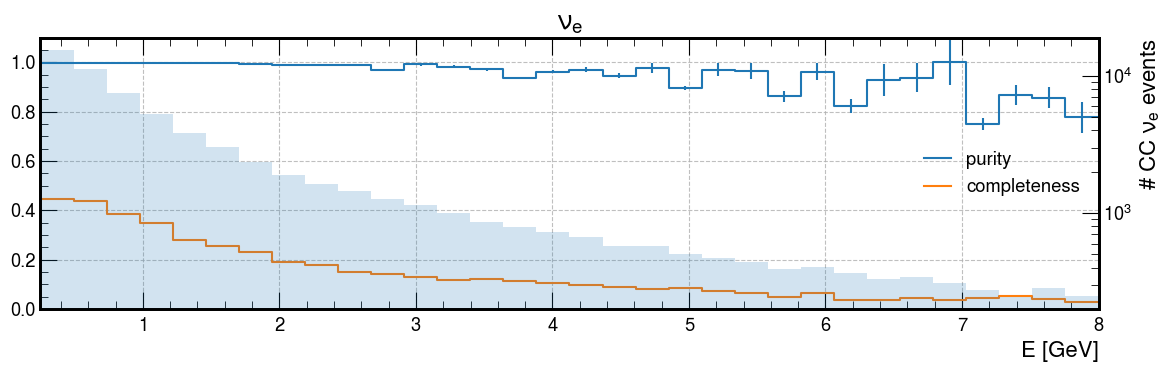

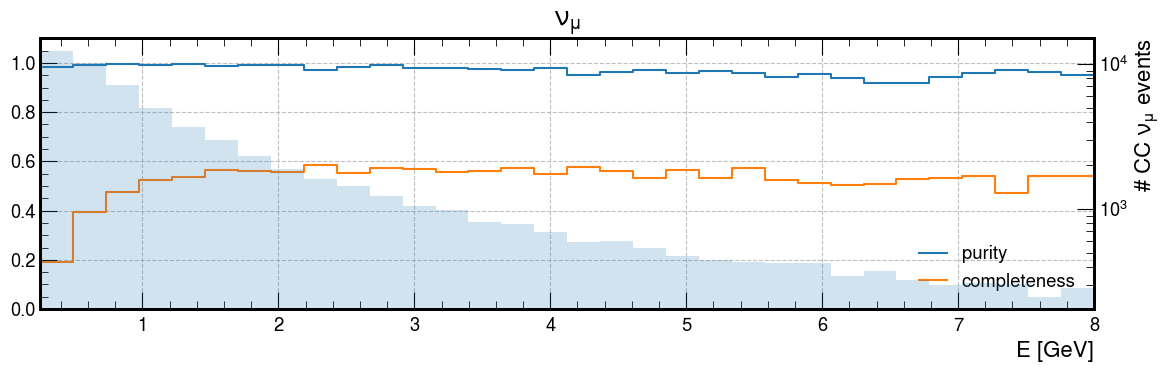

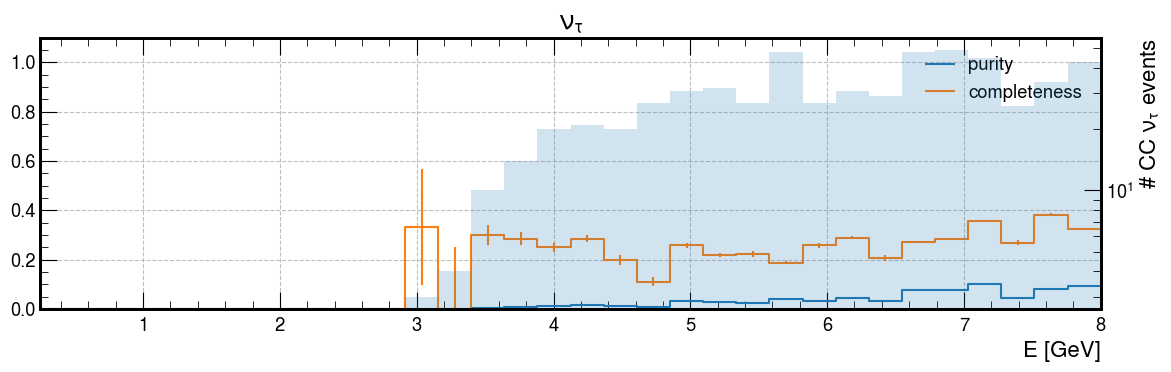

In [69]:
def purity_evolution(df, Ebins, flavour):
    labels = list(map(str, np.arange(0, len(Ebins) + 1)))
    # df = df.filter(
    #     pl.col('rec.NuMomZ')/(pl.col('rec.NuMomX').pow(2) + pl.col('rec.NuMomY').pow(2) + pl.col('rec.NuMomZ').pow(2)).sqrt() >0.7
    # )
    cats = df.with_columns(
        Ecut=df.get_column('rec.Ev').cut(Ebins, maintain_order=True, labels=labels).get_column('category').cast(pl.Int16),
        Ecutt=df.get_column('rec.Ev').cut(Ebins, maintain_order=True).get_column('category')
        )
        
    # print(cats.groupby('Ecutt').agg(pl.col('rec.Ev')).sort('Ecutt'))
    # print(df.get_column('rec.Ev').cut(Ebins, maintain_order=True, labels=labels).filter(pl.col('rec.Ev')<0.11))
    q = (
        cats.groupby('Ecut').agg(
            nb_above = pl.col('rec.pot').filter(pl.col(flavour.cvn) >= 0.5).filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() == flavour.pdg).sum(),
            nb_other_above = pl.col('rec.pot').filter(pl.col(flavour.cvn) >= 0.5).filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() != flavour.pdg).sum(),
            nb_below = pl.col('rec.pot').filter(pl.col(flavour.cvn) < 0.5).filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() == flavour.pdg).sum(),
        ).fill_null(0).with_columns(
            err_nb_above = pl.col("nb_above").sqrt(),
            err_nb_other_above = pl.col("nb_other_above").sqrt(),
            err_nb_below = pl.col("nb_below").sqrt(),
            purity = pl.col('nb_above') /
            (pl.col('nb_other_above') + pl.col("nb_above")),
            completeness = pl.col('nb_above') /
            (pl.col('nb_below') + pl.col("nb_above")),
        ).sort('Ecut').select(
            pl.all(),
            errpurity = (pl.col('purity')/pl.col('nb_above')).pow(2)*((pl.col('nb_other_above')*pl.col('err_nb_above')).pow(2) + 
                                                                        (pl.col('nb_above')*pl.col('err_nb_other_above')).pow(2)).sqrt(),
            errcompleteness = (pl.col('completeness')/pl.col('nb_above')).pow(2)*((pl.col('nb_below')*pl.col('err_nb_above')).pow(2) + 
                                                                                    (pl.col('nb_above')*pl.col('err_nb_below')).pow(2)).sqrt(),
        )
    )
    q2 = (
        cats.groupby('Ecut').agg(
            correct_pdg = pl.col('rec.pot').filter(pl.col('Flavour') == flavour.pdg).filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() == flavour.pdg).count().cast(pl.Float64),
            false_positive = pl.col('rec.pot').filter(pl.col('Flavour') == flavour.pdg).filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() != flavour.pdg).count().cast(pl.Float64),
            incorrect_pdg = pl.col('rec.pot').filter(pl.col('Flavour') != flavour.pdg).filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() == flavour.pdg).count().cast(pl.Float64),
            total_events = pl.col('rec.pot').filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() == flavour.pdg).count().cast(pl.Float64)

        ).fill_null(0).with_columns(
            purity = pl.col('correct_pdg')/
            (pl.col('correct_pdg') + pl.col("false_positive")),
            completeness = pl.col('correct_pdg') /
            (pl.col('correct_pdg') + pl.col("incorrect_pdg")),
        ).fill_nan(0).with_columns(
            err_correct_pdg = eval_err('correct_pdg'),
            err_false_positive = eval_err('false_positive'),
            err_incorrect_pdg = eval_err('incorrect_pdg'),
        ).sort('Ecut').select(
            pl.all(),
            errpurity = eval_err_div('purity','correct_pdg','false_positive','err_correct_pdg','err_false_positive'),
            errcompleteness  = eval_err_div('completeness','correct_pdg','incorrect_pdg','err_correct_pdg','err_incorrect_pdg'),
        )
    )
    # bins_center = (Ebins[1:] + Ebins[:-1])*0.5
    bins_center = Ebins
    bins_width = np.diff(Ebins)
    q = fill_empty_categories(q, labels)
    q2 = fill_empty_categories(q2, labels)
    fig = plt.figure(figsize=(12,4))
    print(q2)
    p = plt.step(bins_center, q2.get_column('purity')[:-1], label='purity')
    # plt.step(bins_center, q.get_column('purity')[:-1], label='purity0')
    c = plt.step(bins_center, q2.get_column('completeness')[:-1], label='completeness')
    # plt.step(bins_center, q.get_column('completeness')[:-1], label='completeness0')

    error_center = (bins_center[1:] + bins_center[:-1])/2
    point_purity = q2.get_column('purity')[1:-1]
    err_purity = q2.get_column('errpurity')[1:-1]
    point_completeness = q2.get_column('completeness')[1:-1]
    err_completeness = q2.get_column('errcompleteness')[1:-1]
    plt.errorbar(error_center, point_purity,ls='none', marker='none', yerr=err_purity, color=p[0].get_color())
    plt.errorbar(error_center, point_completeness,ls='none', marker='none', yerr=err_completeness, color=c[0].get_color())
    plt.title(flavour.name_latex)
    plt.xlabel("E [GeV]")
    plt.xlim(bins_center[0], bins_center[-1])
    plt.ylim(0,1.1)
    plt.legend()
    # plt.xscale('log')
    ax2 = plt.twinx()

    ax2.bar(bins_center[:-1], q2.get_column('total_events')[1:-1], width=bins_width, align="edge", alpha=0.2, log=True)
    ax2.set_ylabel(rf'# CC {flavour.name_latex} events')
    ax2.grid(False)
    # return fig

Ebins = np.logspace(-1,2, 10)
Ebins = np.linspace(0.25,8,33)
df = define_flavour(df)
# dfold = define_flavour(dfold)
purity_evolution(df, Ebins, flavours[12]);
purity_evolution(df, Ebins, flavours[14]);
purity_evolution(df, Ebins, flavours[16]);

In [70]:

# bins = np.linspace(0, 1, 100)

# fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# for f in flavours[3:]:
#     selection = df.filter(np.abs(pl.col("rec.nuPDG")) == f.pdg).filter(pl.col('rec.isCC') == 1).filter(pl.col('rec.Ev') > 3.5)
#     ax.hist(selection['rec.cvnnumu'], bins=bins, label=f.name_latex, histtype='step', weights=np.ones_like(selection['rec.cvnnumu'])*selection['rec.pot']/len(selection['rec.cvnnumu']), density=True)
# selection = df.filter(pl.col('rec.isCC') == 0).filter(pl.col('rec.Ev') > 3.5)
# ax.hist(selection['rec.cvnnumu'], bins=bins, label='NC', histtype='step', weights=np.ones_like(selection['rec.cvnnumu'])*selection['rec.pot']/len(selection['rec.cvnnumu']), density=True)


# plt.legend()
# plt.xlabel("CVN score")
# plt.ylabel("Event distribution (a.u)")
# plt.yscale('log')
# plt.title("CVN numu")

# fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# for f in flavours[3:]:
#     selection = df.filter(np.abs(pl.col("rec.nuPDG")) == f.pdg).filter(pl.col('rec.isCC') == 1).filter(pl.col('rec.Ev') > 3.5)
#     ax.hist(selection['rec.cvnnue'], bins=bins, label=f.name_latex, histtype='step', weights=np.ones_like(selection['rec.cvnnue'])*selection['rec.pot']/len(selection['rec.cvnnue']), density=True)
# selection = df.filter(pl.col('rec.isCC') == 0).filter(pl.col('rec.Ev') > 3.5)
# ax.hist(selection['rec.cvnnue'], bins=bins, label='NC', histtype='step', weights=np.ones_like(selection['rec.cvnnue'])*selection['rec.pot']/len(selection['rec.cvnnue']), density=True)
# plt.legend()
# plt.xlabel("CVN score")
# plt.ylabel("Event distribution (a.u)")
# plt.yscale('log')
# plt.title("CVN nue")

# fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# for f in flavours[3:]:
#     selection = df.filter(np.abs(pl.col("rec.nuPDG")) == f.pdg).filter(pl.col('rec.isCC') == 1).filter(pl.col('rec.Ev') > 3.5)
#     ax.hist(selection['rec.cvnnutau'], bins=bins, label=f.name_latex, histtype='step', weights=np.ones_like(selection['rec.cvnnutau'])*selection['rec.pot']/len(selection['rec.cvnnutau']), density=True)
# selection = df.filter(pl.col('rec.isCC') == 0).filter(pl.col('rec.Ev') > 3.5)
# ax.hist(selection['rec.cvnnutau'], bins=bins, label='NC', histtype='step', weights=np.ones_like(selection['rec.cvnnutau'])*selection['rec.pot']/len(selection['rec.cvnnutau']), density=True)
# plt.legend()
# plt.xlabel("CVN score")
# plt.ylabel("Event distribution (a.u)")
# plt.yscale('log')
# plt.title("CVN nutau")


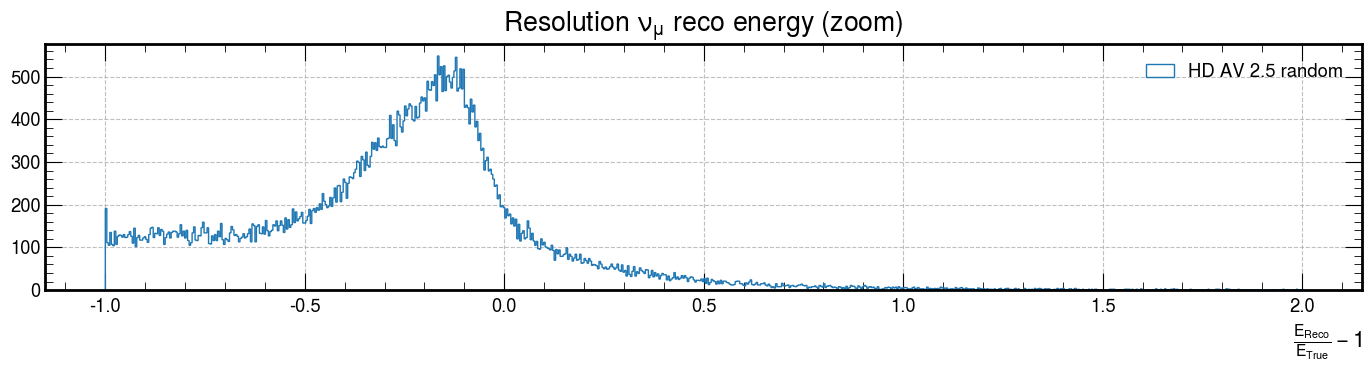

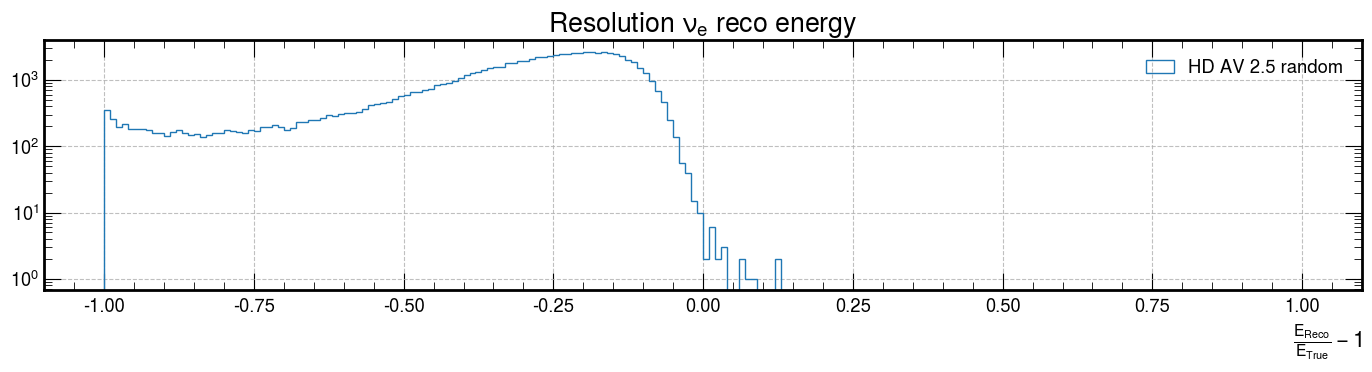

In [71]:
# len_cm = [9.833E-1, 1.786E0, 3.321E0, 6.598E0, 1.058E1,
#           3.084E1, 4.250E1, 6.732E1, 1.063E2, 1.725E2,
#           2.385E2, 4.934E2, 6.163E2, 8.552E2, 1.202E3,
#           1.758E3, 2.297E3, 4.359E3, 5.354E3, 7.298E3, 1.013E4, 1.469E4, 1.910E4, 3.558E4, 4.326E4, 5.768E4, 7.734E4, 1.060E5, 1.307E5]
 
# KE_MeV = [10, 14, 20, 30, 40, 80, 100, 140, 200, 300, 400, 800, 1000, 1400, 2000, 3000,
#           4000, 8000, 10000, 14000, 20000, 30000, 40000, 80000, 100000, 140000,
#           200000, 300000, 400000]
# from scipy.interpolate import CubicSpline
# spl = CubicSpline(len_cm,KE_MeV)

def flavour(pdg):
    return pl.col('rec.nuPDG').abs() == pdg
    # return pl.col('Flavour') == pdg

def energy(pdg):
    En = 'Ev'
    # return (pl.col(En) >=1 ) & (pl.col(En) <= 10)
    return (pl.col(En) >-999 )
def checkEnergy(df):
    E = df.with_columns(
        Ev = pl.col('rec.Ev'),
        Ev_reco = pl.col('rec.Ev_reco'),
        Ev_reco_nue = pl.col('rec.Ev_reco_nue'),
        Ev_reco_numu = pl.col('rec.Ev_reco_numu'),
        LepE = pl.col('rec.LepE')
    ).with_columns(
        Eres = pl.col("Ev_reco")/pl.col("Ev") - 1,
        Eres_nue = pl.col("Ev_reco_nue")/pl.col("Ev") - 1,
        Eres_numu = pl.col("Ev_reco_numu")/pl.col("Ev") - 1,
    )
    return E
E = checkEnergy(df)
# Eold = checkEnergy(dfold)
fig, ax = plt.subplots(1,1,figsize=(14,4))
binsmu = 400
binsmu_z = 800
binse = 200

limmu = 400
limmu_z = 2
lime = 1
# ax = axs[0]
# ax.hist(E.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=binsmu, range=(-1,limmu), log=True, histtype='step', label='HD AV 2.5 random');
# # ax.hist(Eold.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=400, range=(-1,limmu), log=True, histtype='step', label='HD AV');
# ax.set_title(r'Resolution $\nu_\mu$ reco energy')
# ax.set_xlabel(r'$\frac{E_{Reco}}{E_{True}} - 1$')
# ax.legend()
# ax = axs[1]
ax.hist(E.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=binsmu_z, range=(-1,limmu_z), log=False, histtype='step', label='HD AV 2.5 random');
# ax.hist(Eold.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=200, range=(-1,limmu_z), log=True, histtype='step', label='HD AV');
ax.set_title(r'Resolution $\nu_\mu$ reco energy (zoom)')
ax.set_xlabel(r'$\frac{E_{Reco}}{E_{True}} - 1$')
ax.legend()
plt.figure(figsize=(14,4))
plt.hist(E.filter(flavour(12)).filter(pl.col('rec.isCC')==1).filter(energy(12))['Eres_nue'], bins=binse, range=(-1, lime),log=True, histtype='step', label='HD AV 2.5 random');
# plt.hist(Eold.filter(flavour(12)).filter(pl.col('rec.isCC')==1).filter(energy(12))['Eres_nue'], bins=200, range=(-1, lime),log=True, histtype='step', label='HD AV');
plt.title(r'Resolution $\nu_e$ reco energy')
plt.xlabel(r'$\frac{E_{Reco}}{E_{True}} - 1$')
plt.legend()

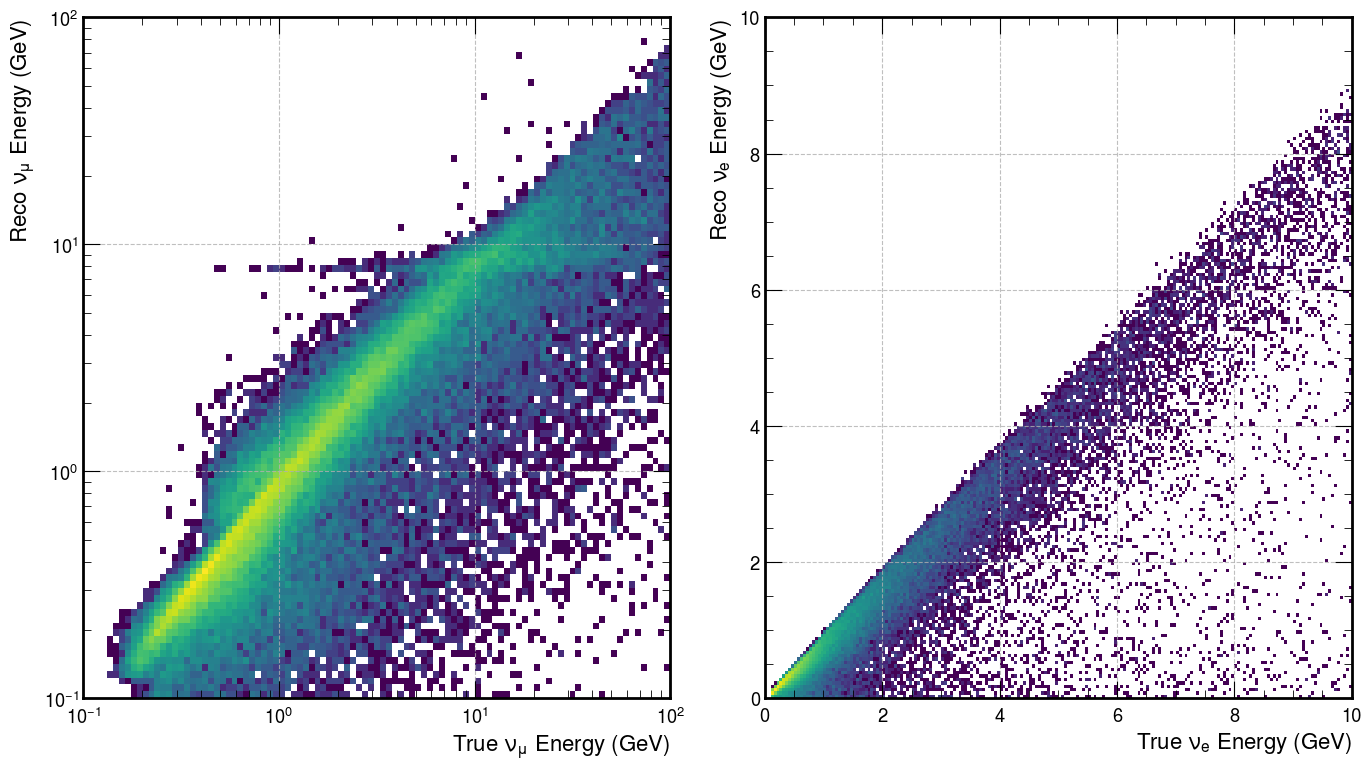

In [72]:

E = checkEnergy(df)
# Eold = checkEnergy(dfold)
Emu = E.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14)).filter(pl.col('rec.TrackMomMethodNumu')!=-10)
Ee = E.filter(flavour(12)).filter(pl.col('rec.isCC')==1).filter(energy(12))
ax:plt.Axes
binsx = np.logspace(-1,np.log10(100),100)
binsy = np.logspace(-1,np.log10(100),100)
# binsx = np.linspace(0.,20,200)
# binsy = np.linspace(0.,20,200)
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].hist2d(Emu['Ev'], Emu['Ev_reco_numu'], bins=(binsx,binsy), range=((0,10),(0,10)), norm = LogNorm())
ax[0].set_xlabel(rf'True {flavours[14].name_latex} Energy (GeV)')
ax[0].set_ylabel(rf'Reco {flavours[14].name_latex} Energy (GeV)')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].hist2d(Ee['Ev'], Ee['Ev_reco_nue'], bins=(200,200), range=((0,10),(0,10)), norm = LogNorm());
ax[1].set_xlabel(rf'True {flavours[12].name_latex} Energy (GeV)')
ax[1].set_ylabel(rf'Reco {flavours[12].name_latex} Energy (GeV)')
plt.show()

In [73]:

E.filter((pl.col('rec.TrackMomMethodNumu')!=-1) & (~pl.col('rec.cvnnue').is_null()) & (pl.col('rec.Ev_reco_nue')==0))['Ev_reco_nue']

Ev_reco_nue
f32


In [77]:
dftest = df.filter((pl.col('rec.Ev')>2) & (pl.col('rec.Ev')<5)).filter(pl.col("rec.isCC")==1)

# dftest = dftest.filter(
#     pl.col('rec.NuMomZ')/(pl.col('rec.NuMomX').pow(2) + pl.col('rec.NuMomY').pow(2) + pl.col('rec.NuMomZ').pow(2)).sqrt() >0.7
# )
nutotal = len(dftest)
print(f'Total # of events: {nutotal}, which CC: {len(dftest.filter(pl.col("rec.isCC")==1))}')
nue = len(dftest.filter(pl.col("rec.nuPDG").abs() == 12))
numu = len(dftest.filter(pl.col("rec.nuPDG").abs() == 14))
nuereco = len(dftest.filter(pl.col('Flavour')==12))
numureco = len(dftest.filter(pl.col('Flavour')==14))
# nutau = len(dftest.filter(pl.col('Flavour')==16))
nunot = len(dftest.filter(pl.col('Flavour')==0))
print(f'Nue events: {nue*100/nutotal:.2f}%, Reconstructed nue: {nuereco*100/nue:.2f}%')
print(f'Numu events: {numu*100/nutotal:.2f}%, Reconstructed numu: {numureco*100/numu:.2f}%')
# print(f'Reco middle: {nutau*100/nutotal:.2f}%')
print(f'Fail reco: {nunot*100/nutotal:.2f}%')
print(f'Nue or Numu reco: {(nuereco+numureco)*100/nutotal:.2f} %')

Total # of events: 24664, which CC: 24664
Nue events: 50.43%, Reconstructed nue: 13.89%
Numu events: 49.01%, Reconstructed numu: 57.87%
Fail reco: 37.19%
Nue or Numu reco: 35.37 %


In [78]:
def reprocess_flavours(df:pl.DataFrame, minScore:dict) -> pl.DataFrame:
    df = df.with_columns(
        Flavour = pl.when(get_max()==None).then(-1).otherwise(
        pl.when(pl.col('rec.cvnnue') >= minScore[12]).then(12).otherwise(
        pl.when(pl.col('rec.cvnnumu') >= minScore[14]).then(14).otherwise(
        pl.when(pl.col('rec.cvnnc')>=minScore[0]).then(0).otherwise(
        pl.when(pl.col('rec.cvnnutau') >= minScore[16]).then(16).otherwise(-2))
        )))
    )
    return df

def create_categories(df:pl.DataFrame, Ebins):
    labels = list(map(str, np.arange(0, len(Ebins) + 1)))
    # df = df.filter(
    #     pl.col('rec.NuMomZ')/(pl.col('rec.Ev')).sqrt() > 0.8
    # )
    cats = df.with_columns(
        Ecut=df.get_column('rec.Ev').cut(Ebins, maintain_order=True, labels=labels).get_column('category').cast(pl.Int16),
        Ecutt=df.get_column('rec.Ev').cut(Ebins, maintain_order=True).get_column('category')
        )
    
    cats = cats.filter(pl.col('rec.cvnnue')>=0)#.filter((pl.col('rec.Ev')<5) | (pl.col('rec.Ev')>10))

    return cats

def pandc(cats, Ebins, flavour, type='cc'):
    labels = list(map(str, np.arange(0, len(Ebins) + 1)))


    cats = create_categories(cats, Ebins)
    q:pl.DataFrame
    qcc = (
        cats.filter(
            pl.col('rec.isCC') == 1 # filter for better result
        ).select( # make a selection of when the pdg matched the one requested
            match_pdg  = pl.when(( pl.col('rec.nuPDG').abs()==flavour.pdg )).then(1).otherwise(0),
            cnvscore = pl.col(flavour.cvn),
            Ecut = pl.col('Ecut'),
            Ecutt = pl.col('Ecutt')
        ).sort( # sort by score, this is needed to count the number of events later
            pl.col('cnvscore')
        ).groupby('Ecut').agg(
            pl.all().exclude('Ecutt'),
            Ecutt = pl.col('Ecutt').first().cast(pl.Utf8)
        ).lazy()
    )
    qnc = (
        cats.select( # make a selection of when the pdg matched the one requested
            match_nc  = (1-pl.col('rec.isCC')),
            cnvscore = pl.col(flavour.cvn),
            Ecut = pl.col('Ecut'),
            Ecutt = pl.col('Ecutt')
        ).sort( # sort by score, this is needed to count the number of events later
            pl.col('cnvscore')
        ).groupby('Ecut').agg(
            pl.all().exclude('Ecutt'),
            Ecutt = pl.col('Ecutt').first().cast(pl.Utf8)
        ).lazy()
    ).lazy()
    
    if type == 'cc':
        q = qcc.collect()
        match = q.get_column('match_pdg').to_numpy() # give me n arrays (n->Ebins) with information of when pdg was the same or not
    else:
        q = qnc.collect()
        match = q.get_column('match_nc').to_numpy() # give me n arrays (n->Ebins) with information of when pdg was the same or not

    # for each Ebins, invert the array and sum. This gives me the amount of events above a "threshold" where the pdg was equal to one I am asking
    # Ex: threshold=[0.2,0.5,0.6, 0.8]
    # match = [1,0,1,1] -> inverted = [1,1,0,1]
    # this means that the cumulative sum is [1,2,2,3] -> inverted = [3,2,2,1]
    # that translates as: 3 events above 0.2, 2 events above 0.5.. and so on
    match = [v[::-1].cumsum()[::-1] for v in match ]

    # total number of events per threshold matching: needs only to reduce one each step
    total_num_match = [np.arange(len(v), 0, -1) for v in match]

    # total number of events is stored in the first item of the cumulative sum
    total_num = [v[0] for v in match]
    q = q.with_columns(
        pl.Series(name='Total_events', values=total_num)
    )
    cvnscore = q.get_column('cnvscore').to_numpy()
    purity = [m/t for m, t in zip(match,total_num_match)]
    completess = [m/t for m, t in zip(match,total_num)]
    
    return purity, completess, cvnscore, q


In [79]:

import matplotlib
def plot_pcand(purity, completeness, cvnscore, q:pl.DataFrame, flavour = flavours[12], columns=3, type='vs', idx_slice = 1 , **kwargs):

    intervals = q.get_column('Ecutt').to_numpy()
    intervals = [rf'E({flavour.name_latex}) = {inter}' for inter in intervals]
    total_events = q.get_column('Total_events').to_numpy()
    if 'figsize' in kwargs:
        figsize=kwargs.pop('figsize')
    else:
        figsize=(14,10)

    nplots = len(intervals)
    rows = nplots//columns
    last_empty= False
    if nplots%columns != 0:
        last_empty = True
        rows+=1

    fig, axes = plt.subplots(rows,columns,figsize=figsize)
    for i, (inter,ax) in enumerate(zip(intervals,axes.flat)):
        ax:plt.Axes
        the_slice = np.index_exp[::idx_slice]
        p = purity[i][the_slice]
        c = completeness[i][the_slice]
        thresholds = cvnscore[i][the_slice]

        if type=='vs':
            ax.plot(thresholds, p, label='Purity', **kwargs)
            ax.plot(thresholds, c, label='Completeness', **kwargs)
        elif type=='merit':
            ax.plot(thresholds, p*c, **kwargs)
        else:
            print('Wrong option')
            return

        ax.plot([],[],' ', label=f'Entries: {total_events[i]}')
        ax.set_xlabel('CVN Score threshold')
        ax.set_ylabel('Value')
        ax.legend(frameon=True, fontsize=12, title=inter, title_fontsize=12)
        if type=='merit':
            ax.set_ylabel(r'Purity $\times$ Completeness')

    plt.tight_layout() 
    if type=='merit':
        return

    if last_empty:
        ax = axes.flat[-1]
        fig.delaxes(ax)


In [84]:

# Ebins = np.logspace(-1,2, 10)
Ebins = np.linspace(0.25,5,33)
Ebins = [0.1,5,10,20,100] #keep up to 100 to avoid the +infinity
Ebins = [0.1,4,10,60,100] #keep up to 100 to avoid the +infinity

Estr = list(map(str, Ebins))

pdgcode = 12
flavour = flavours[pdgcode]
intervals = [f'E = ({c}-{b}] GeV' for c, b in zip(Estr[:-1], Estr[1:])]
nInt = len(intervals)

keys = [12,14,16,0]


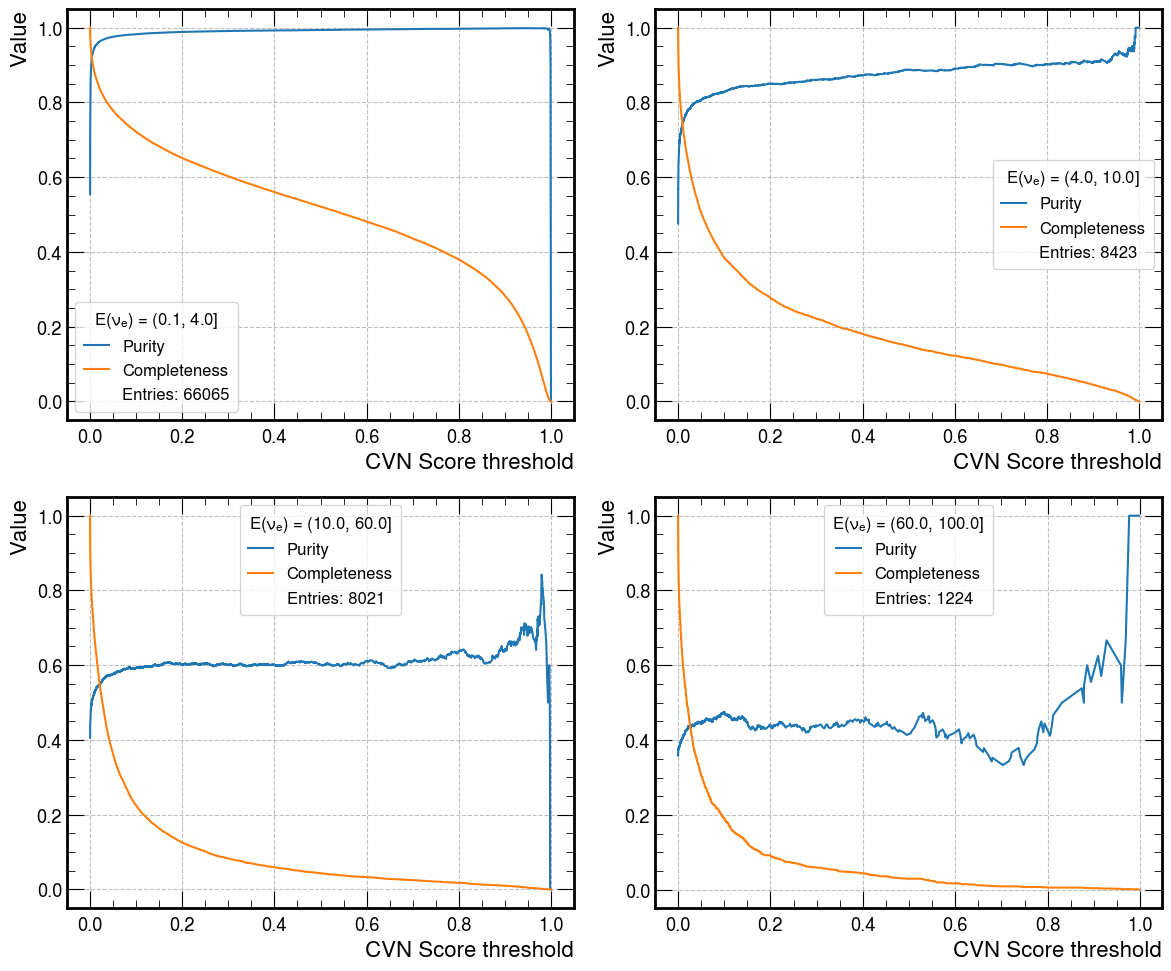

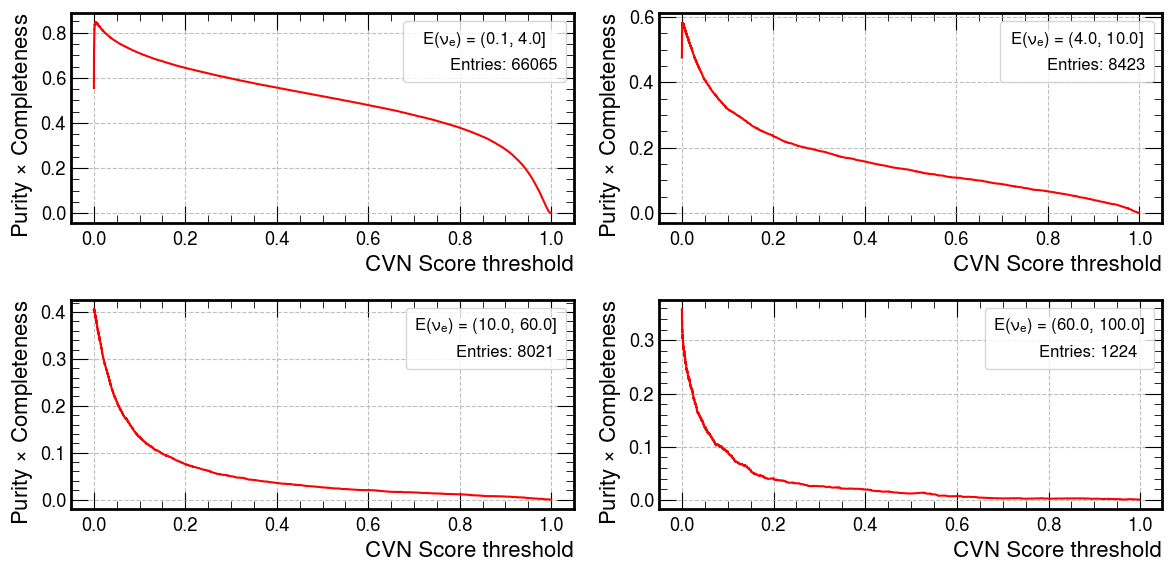

In [85]:
flavour = flavours[12]
purity, completeness, thresholds, q = pandc(df,Ebins,flavour,'cc')
plot_pcand(purity,completeness,thresholds, q, flavour, columns=2, idx_slice=1, figsize=(12,10))
plot_pcand(purity,completeness,thresholds, q, flavour,2,type='merit', idx_slice=1 ,figsize=(12,6), c='r')

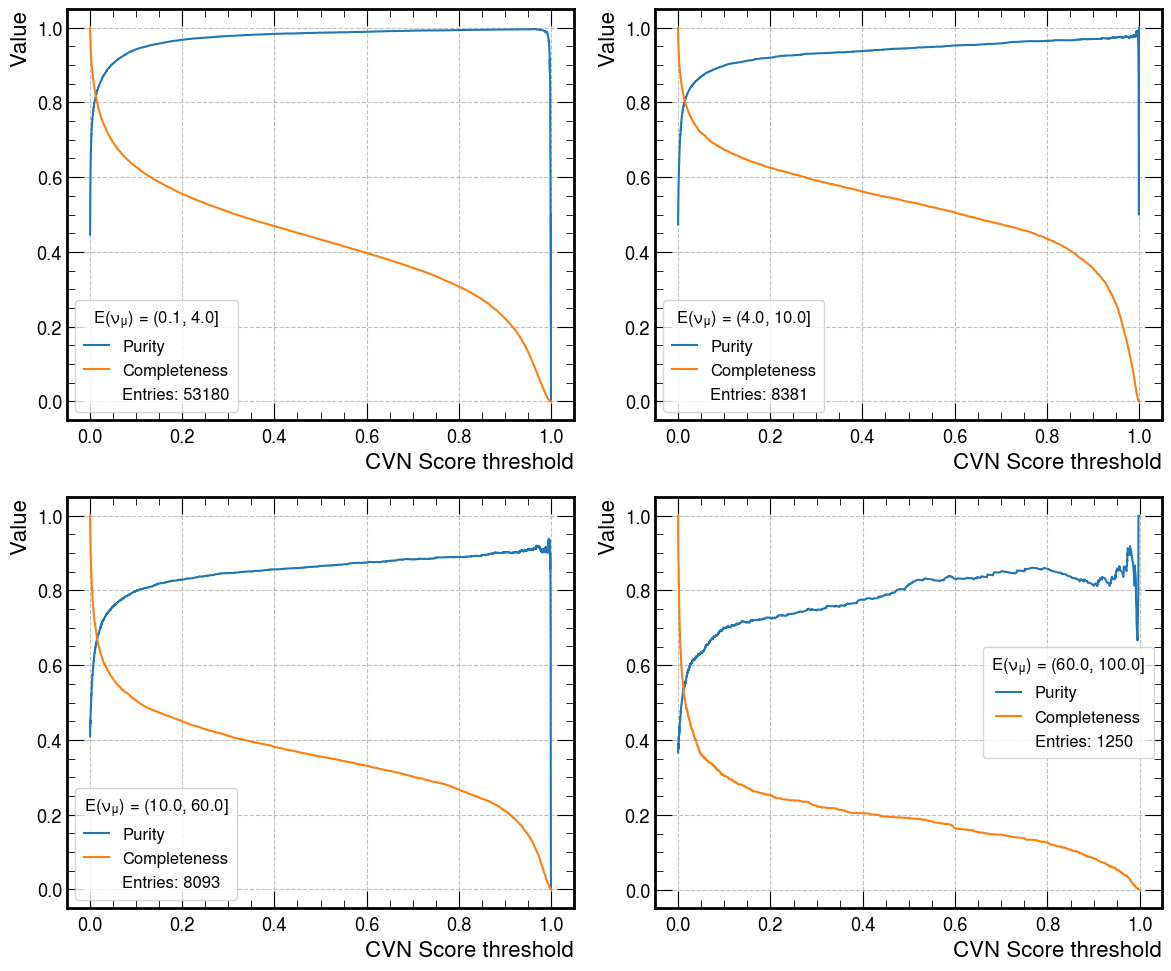

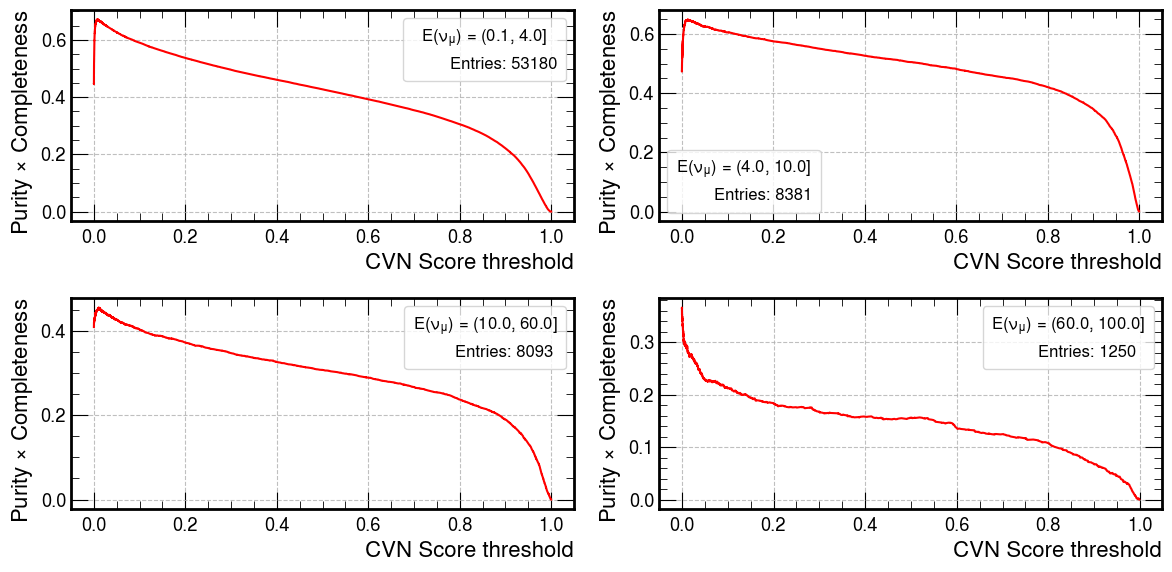

In [86]:
flavour = flavours[14]
purity, completeness, thresholds, q = pandc(df,Ebins,flavour,'cc')
plot_pcand(purity,completeness,thresholds, q, flavour, columns=2, idx_slice=1, figsize=(12,10))
plot_pcand(purity,completeness,thresholds, q, flavour,2,type='merit', idx_slice=1 ,figsize=(12,6), c='r')

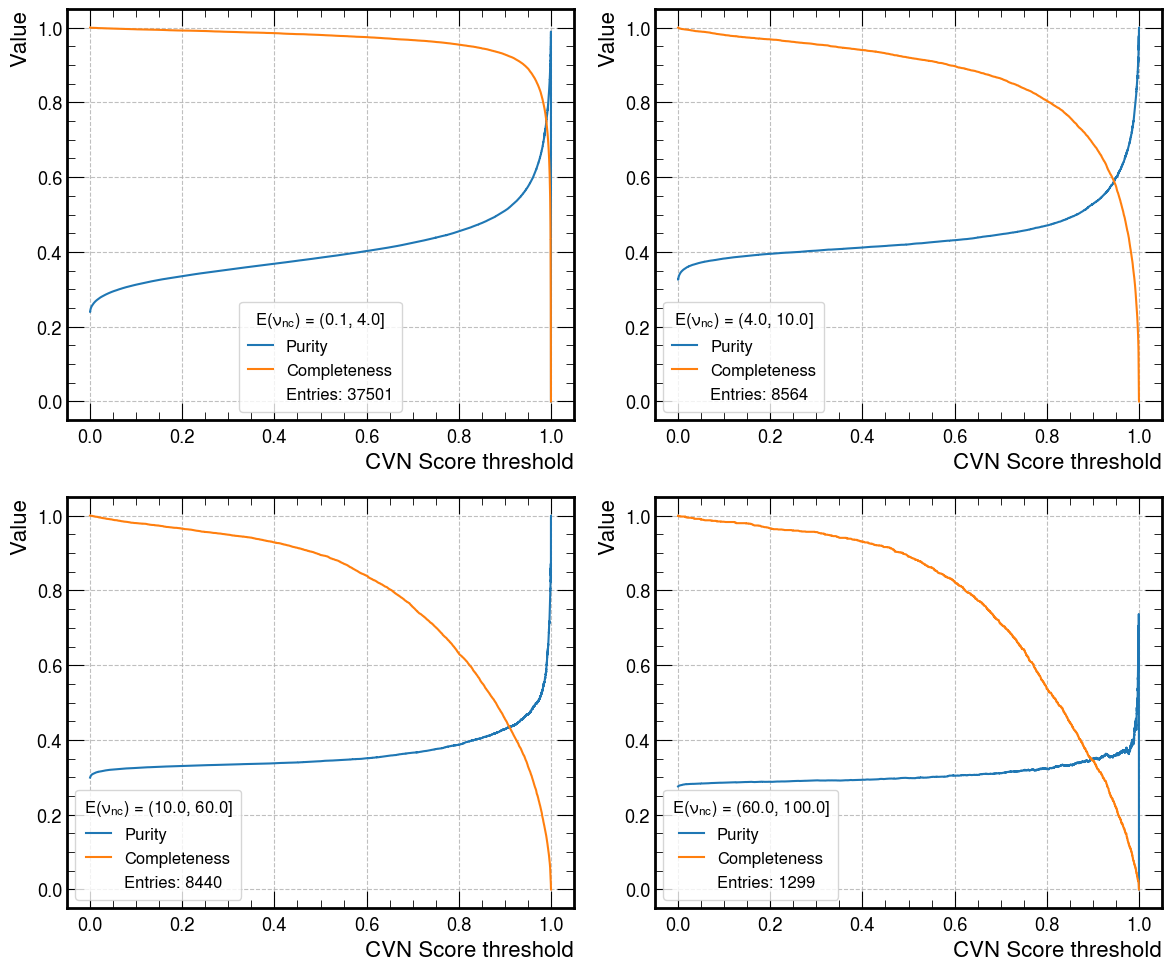

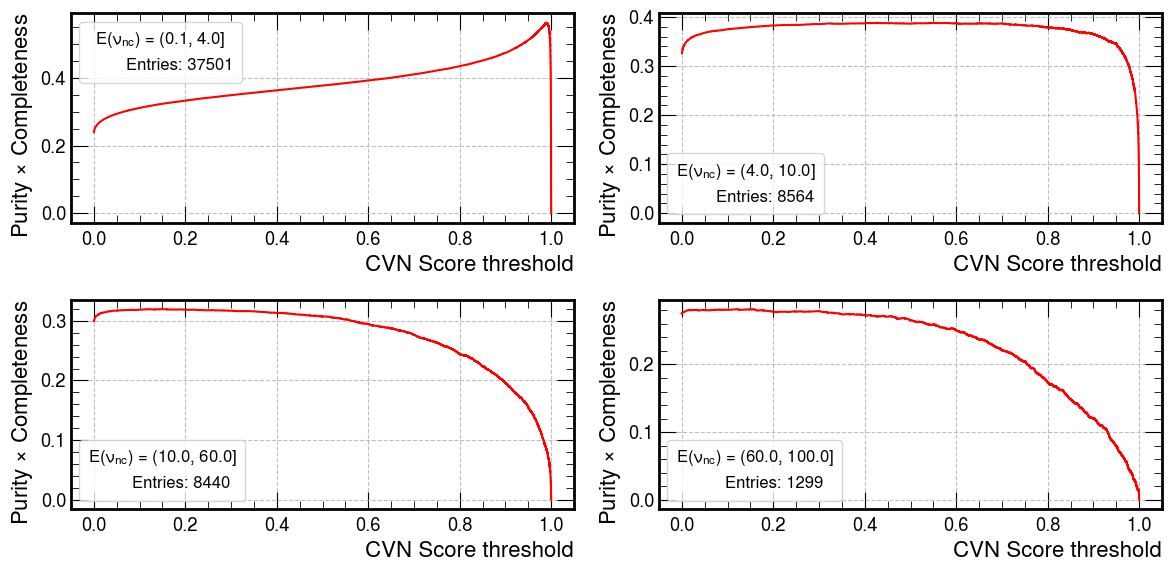

In [87]:
flavour = flavours[0]
purity, completeness, thresholds, q = pandc(df,Ebins,flavour,'nc')
plot_pcand(purity,completeness,thresholds, q, flavour, columns=2, idx_slice=1, figsize=(12,10))
plot_pcand(purity,completeness,thresholds, q, flavour,2,type='merit', idx_slice=1 ,figsize=(12,6), c='r')


In [ ]:
safe_distance = 30
xlim = 363.376 - safe_distance
ylim = 607.829 - safe_distance
zmin = -0.87625 + safe_distance
zmax = 1393.46 - safe_distance
def check_fiducial():
    return (pl.col('rec.vtx_x').abs() <= xlim) & \
    (pl.col('rec.vtx_y').abs() <= ylim) & \
    (pl.col('rec.vtx_z') >= zmin) & \
    (pl.col('rec.vtx_z') <= zmax)

check = df.filter(
   ( pl.col('rec.cvnnue').is_null()) & (pl.col('rec.isCC') == 1) & (pl.col('rec.Ev') >= 1)
).filter(
    check_fiducial()
)
print(
check.sort(['rec.subrun', 'rec.event'])[['rec.subrun', 'rec.event', 'rec.Ev', 'rec.vtx_x', 'rec.vtx_y', 'rec.vtx_z', 'rec.Q2' ]]
)


shape: (26, 7)
┌────────────┬───────────┬──────────┬─────────────┬─────────────┬─────────────┬──────────┐
│ rec.subrun ┆ rec.event ┆ rec.Ev   ┆ rec.vtx_x   ┆ rec.vtx_y   ┆ rec.vtx_z   ┆ rec.Q2   │
│ ---        ┆ ---       ┆ ---      ┆ ---         ┆ ---         ┆ ---         ┆ ---      │
│ i32        ┆ i32       ┆ f32      ┆ f32         ┆ f32         ┆ f32         ┆ f32      │
╞════════════╪═══════════╪══════════╪═════════════╪═════════════╪═════════════╪══════════╡
│ 5086       ┆ 12        ┆ 1.061922 ┆ -289.411957 ┆ 524.229431  ┆ 534.953064  ┆ 0.057369 │
│ 5385       ┆ 1         ┆ 3.504376 ┆ 9.926286    ┆ 428.457855  ┆ 622.557129  ┆ 0.003671 │
│ 5978       ┆ 7         ┆ 1.270662 ┆ 3.425936    ┆ -543.666687 ┆ 1049.283569 ┆ 0.22675  │
│ 6421       ┆ 11        ┆ 2.189661 ┆ 5.915492    ┆ -52.874947  ┆ 1296.932861 ┆ 0.28398  │
│ 8846       ┆ 10        ┆ 4.323555 ┆ 267.217163  ┆ 12.347657   ┆ 158.850235  ┆ 0.412667 │
│ 8846       ┆ 19        ┆ 1.173876 ┆ 98.826447   ┆ 417.79364   ┆ 343.87356

In [ ]:
df.filter(
    pl.col('rec.cvnnue')>=0.98
)[['rec.cvnnue', 'rec.cvnnumu', 'rec.cvnnutau', 'rec.cvnnc']]

rec.cvnnue,rec.cvnnumu,rec.cvnnutau,rec.cvnnc
f32,f32,f32,f32
0.998963,0.000035,0.000998,0.000004
0.999378,0.000006,0.00061,0.000005
0.998212,0.000419,0.001363,0.000005
0.998799,0.000017,0.001167,0.000017
0.998193,0.000019,0.001754,0.000034
0.998778,0.000005,0.001201,0.000017
0.999401,0.000098,0.000335,0.000166
0.998114,0.00003,0.00135,0.000505
0.998013,0.000066,0.001868,0.000053


In [ ]:
test = df
test = test.filter(pl.col('rec.cvnnue').is_not_null())
# plt.hist(df['rec.cvnnc'], bins=np.linspace(0,1,400));
test = df.sort('rec.cvnnc').filter(pl.col('rec.cvnnc')>=0)
iscc = test.get_column('rec.isCC').to_numpy()
isnotcc = -1*(iscc-1)
cnvscore = test.get_column('rec.cvnnc').to_numpy()
cumiscc = isnotcc[::-1].cumsum()[::-1]
total_num = np.arange(len(cumiscc), 0, -1)

nice_purity = cumiscc/total_num
nice_completeness = cumiscc/cumiscc[0]
def get_p(test:pl.DataFrame, thresholds):
    purity = [0 for _ in thresholds]
    for i, thre in enumerate(thresholds):
        test = test.filter(pl.col('rec.cvnnc')>=thre)
        tnew = test.groupby('rec.isCC').agg(
            pl.count().alias("count")
        )
        correct_nc = tnew.filter(pl.col('rec.isCC')==0).get_column('count')[0]
        false_nc = tnew.filter(pl.col('rec.isCC')==1).get_column('count')[0]
        pu = correct_nc/(correct_nc+false_nc)
        purity[i] = pu
    return purity
# purity = get_p(test, thresholds)


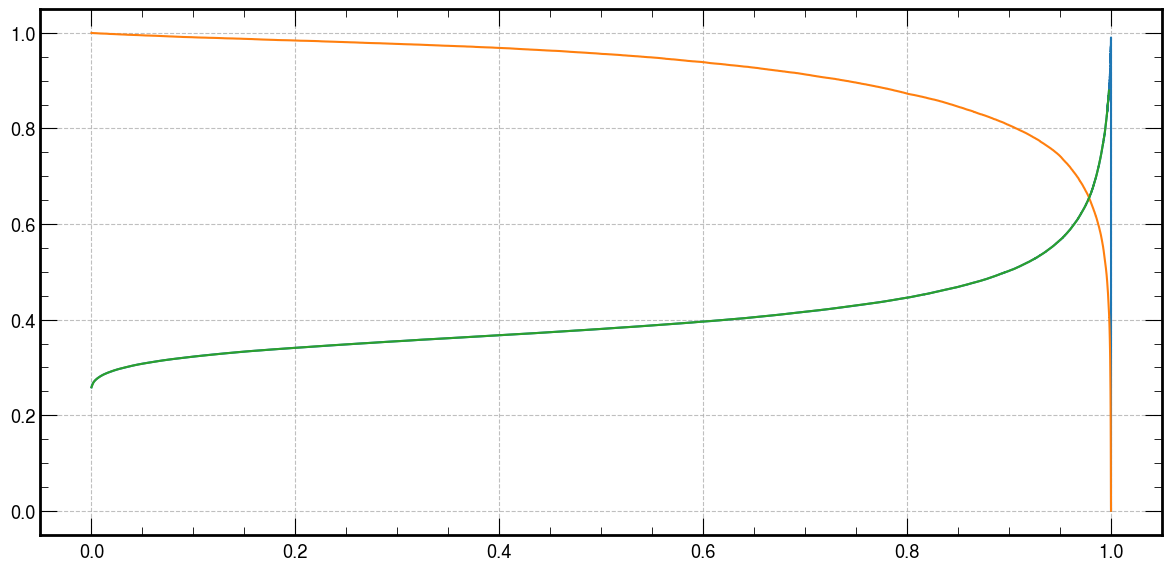

In [ ]:
plt.plot(cnvscore, nice_purity)
plt.plot(cnvscore, nice_completeness)
plt.plot(thresholds, purity)
# plt.ylim(0,0.99)

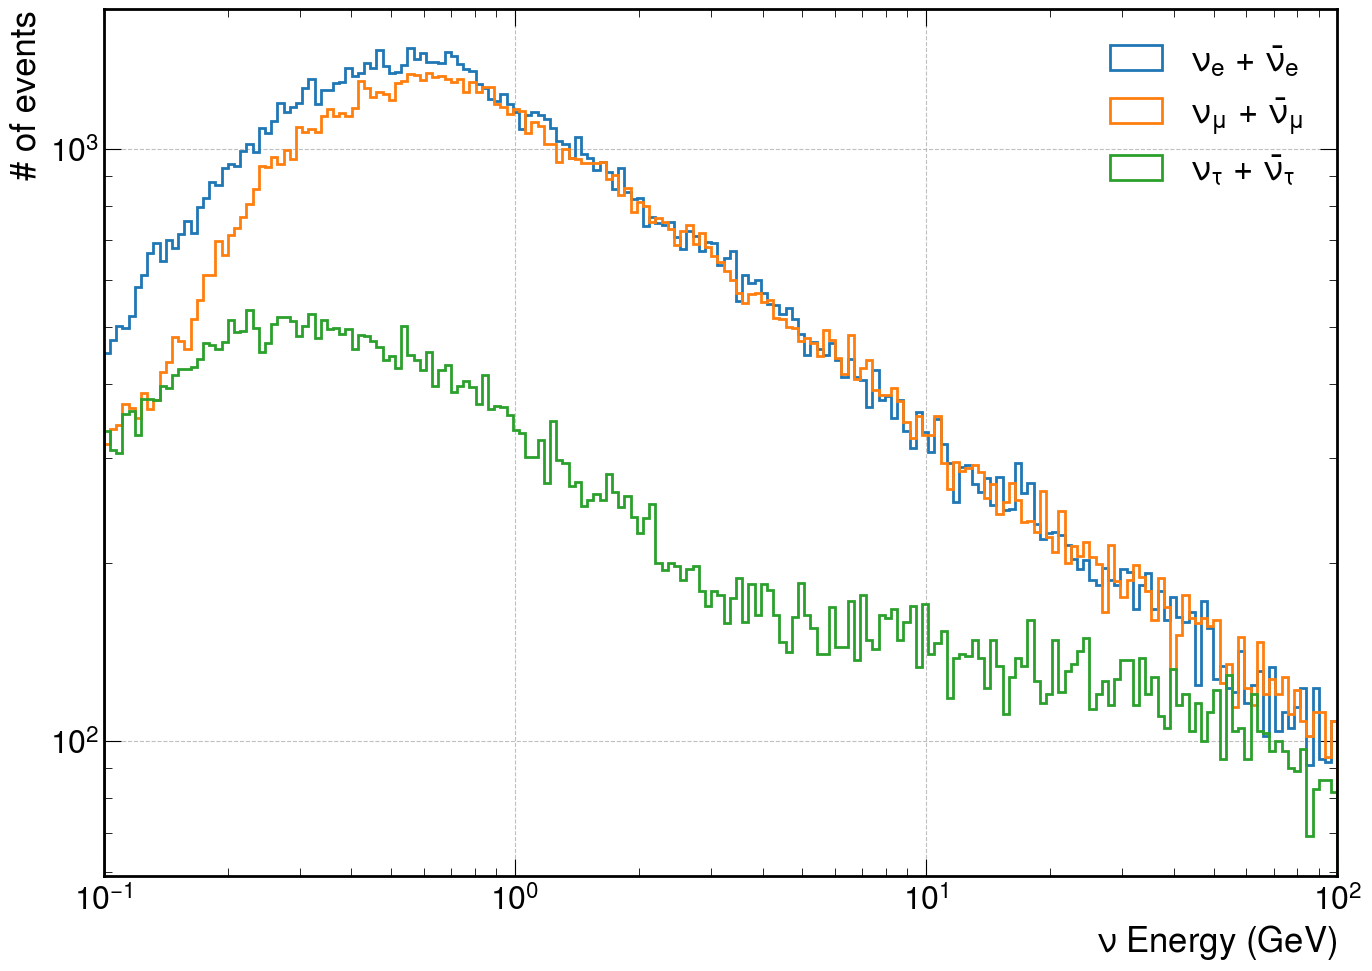

In [ ]:
Enue = df.filter(flavour(12))['rec.Ev']
Enumu = df.filter(flavour(14))['rec.Ev']
Enutau = df.filter(flavour(16))['rec.Ev']
bins=np.logspace(-1,2,200)
plt.figure(figsize=(14,10))
plt.hist(Enue, bins=bins, histtype='step', label=r'$\nu_e$ + $\bar{\nu}_e$', lw=2);
plt.hist(Enumu, bins=bins, histtype='step', label=r'$\nu_\mu$ + $\bar{\nu}_\mu$', lw=2);
plt.hist(Enutau, bins=bins, histtype='step', label=r'$\nu_\tau$ + $\bar{\nu}_\tau$', lw=2);
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=23)
plt.ylabel('# of events', fontsize=25)
plt.xlabel(r'$\nu$ Energy (GeV)', fontsize=25)
plt.xlim(0.1,100)
plt.legend(fontsize=25)

rec.nuPDG
i32
12
12
-12
12
12
12
12
12
-12
